In [28]:
# DataFrame
import pandas as pd
import numpy as np

# Matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# Keras
from tensorflow import keras

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Utility
import re
import os
from collections import Counter
import logging
import time
import pickle
import itertools

DATASET_COLUMNS = ['date', 'likes', 'replies', 'retweets', 'content']

TEXT_CLEANING_RE = "@\S+|https?:\S+|[^A-Za-z0-9]+"
POSITIVE = 'POSITIVE'
NEUTRAL = 'NEUTRAL'
NEGATIVE = 'NEGATIVE'
SENTIMENT_THRESHOLDS = (0.4, 0.7)

MODEL_PATH='/content/drive/MyDrive/Data Science/Models/twitter_sentiment_model/'

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
df = pd.read_csv('/content/drive/MyDrive/Data Science/Datasets/lastofus10k.csv', names=DATASET_COLUMNS)

In [21]:
df

,date,likes,replies,retweets,content
0,2023-02-11 18:03:31+00:00,0,0,0,🥹😢They’re laying it on thick with the Henry an...
1,2023-02-11 18:03:29+00:00,0,0,0,@QuanChinooo Yeah but I was thinking my favori...
2,2023-02-11 18:03:28+00:00,0,0,0,i'm glad the last of us chose to skip pittsburgh
3,2023-02-11 18:03:27+00:00,0,0,0,"This is a familiar face to some, we’d like to ..."
4,2023-02-11 18:03:19+00:00,0,0,0,time to start the last of us
...,...,...,...,...,...
9995,2023-02-11 06:25:01+00:00,0,0,0,The last of us Ep. 5 IS A MASTERPIECE
9996,2023-02-11 06:24:48+00:00,20,1,0,The “Last of Us” newest episode has me 😡 &amp;...
9997,2023-02-11 06:24:45+00:00,6,0,0,we only have 4 episodes left of the last of us...
9998,2023-02-11 06:24:42+00:00,0,0,0,Little Hugs can Dry big Tears...\nLittle Candl...


# Load Model

In [56]:
tokenizer = pickle.load(open(MODEL_PATH+'tokenizer.pkl', 'rb'))

In [29]:
model = keras.models.load_model(MODEL_PATH+'model')

# Data Pre-processing

In [13]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [70]:
stop_words.append('last')
stop_words.append('us')

In [71]:
def preprocess(text, stem=False):
  text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return ' '.join(tokens)

In [73]:
df.content = df.content.apply(lambda x: preprocess(x))

In [77]:
x = pad_sequences(tokenizer.texts_to_sequences(df.content), maxlen=300)

# Predict / Label Tweets

In [1]:
def decode_sentiment(score, include_neutral=True):
  if include_neutral:
    label = NEUTRAL
    if score <= SENTIMENT_THRESHOLDS[0]:
      label = NEGATIVE
    elif score >= SENTIMENT_THRESHOLDS[1]:
      label = POSITIVE
    return label
  else:
    return NEGATIVE if score < 0.5 else POSITIVE

In [51]:
def predict(text, include_neutral=True):
  start_at = time.time()
  x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
  score = model.predict([x_test])[0]
  label = decode_sentiment(score, include_neutral=include_neutral)

  return {'label': label, 'score': float(score), 'elapsed_time': time.time()-start_at}

In [75]:
print(df.loc[105]['content'])
predict(df.loc[105]['content'])

person enjoys hbo dramas love scary stuff watch
1/1 [==============================] - 0s 56ms/step


{'label': 'POSITIVE',
 'score': 0.8780431747436523,
 'elapsed_time': 0.10211586952209473}

In [78]:
%%time
predicted = []
scores = model.predict(x, verbose=1, batch_size=1000)
predicted = [decode_sentiment(score) for score in scores]

10/10 [==============================] - 20s 2s/step
CPU times: user 30.7 s, sys: 4.25 s, total: 34.9 s
Wall time: 20.6 s


In [79]:
df['label'] = predicted

# Data Analysis

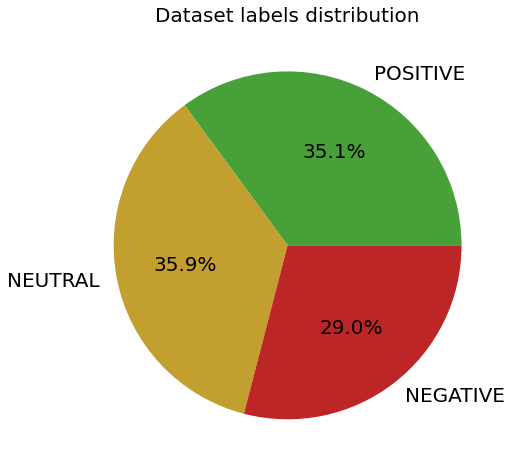

In [143]:
label_cnt = Counter(df.label)

plt.figure(figsize=(16,8))
plt.pie(label_cnt.values(), labels = label_cnt.keys(), colors=['#48a138', '#c29f2f', '#bd2626'], autopct='%.1f%%', textprops={'fontsize': 20})
plt.title("Dataset labels distribution", fontsize=20)
plt.show()

Popularity score:

In [86]:
weights = {
    "likes": 0.5,
    "retweets": 0.3,
    "replies": 0.1
}

df["popularity_score"] = df[["likes", "retweets", "replies"]].mul(list(weights.values()), axis=1).sum(axis=1)
df["popularity_score"] = df["popularity_score"] / df["popularity_score"].max()

In [108]:
sentiment = ['Positive', 'Neutral', 'Negative']
avg_pop = [np.average(df[df.label == 'POSITIVE']['popularity_score'].values.tolist()), 
           np.average(df[df.label == 'NEUTRAL']['popularity_score']), 
           np.average(df[df.label == 'NEGATIVE']['popularity_score'])]

avg_pop = avg_pop / np.max(avg_pop)

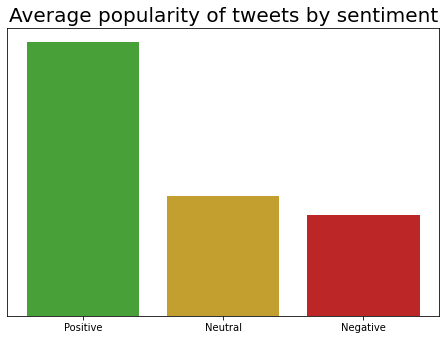

In [145]:
COLORS = ['#48a138', '#c29f2f', '#bd2626']

fig = plt.figure()
fig.add_axes([0,0,1,1])
plt.bar(sentiment, avg_pop, color=COLORS)
plt.title('Average popularity of tweets by sentiment', fontsize=20)
plt.tick_params(left = False, labelleft = False)
plt.show()